# Assigment 1
## Oscar Engelbrektson
## CS156, Prof Albrecht, Fall 2019


Extract the date and base speed for a benchmark of your choice.
Plot the data in a semi-log plot.
Now train a linear model to fit your plot.
How well is Moore's Law holding up?

In [19]:
import pandas as pd
df = pd.read_csv("/Users/oscarengelbrektson/Documents/benchmarks.csv", delimiter=";")

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Pre-processing

Through reviewing the format of the testID column in Excel, I have come to the following conclusions:
1. It consists of three components: cpu-date-time, separated by "-".
2. The date is reported in two different formats: for dates before 1999, the year is reported with two digits, e.g. 97; for dates 1999 and forward, the year is reported with four digits, e.g. 2000.
3. For every benchmark I have perused, there are a number of rows which do not abide by the above and instead have the format "pXYZ" where XYZ are digits.

Given these observations, to extract the the date, I will:
1. Select an arbitrary benchmark
2. Delete rows where testID starts with p
3. Extract the date component of testID by taking the substring in between two "-".
4. Add "19" to the beggining to any date component starting with "9" (I am confident there are no observations from the 9th millenium).
5. Convert it to type Datetime


As it turns out, the benchmark with the most observations is '483.xalancbmk'- df['benchName'].value_counts().argmax() -> '483.xalancbmk'. Coincidentally, the earliest observations in the benchmark are from 2006, sidestepping the date formatting change post-1998. Furthermore, it has no testID entries of the form "pXYZ". Hence, in the interest of saving myself some data pre-processing work, I have decided to use the '483.xalancbmk' benchmark. This means Steps 2 and 4 will not be neccessary; Steps 1, 3, 5 still apply.

In [20]:
#Step 1: Extracting the '483.xalancbmk' benchmark
df = df.loc[df['benchName'] == '483.xalancbmk']

#Step 3: Extract date from testID
df["date"] = df["testID"].str.extract(pat = '-(.+?)-')

#Step 5: Convert to date to type datetime
df["date"] = pd.to_datetime(df["date"])

In [21]:
#Did it work?
df["date"].describe()

count                    3173
unique                    474
top       2011-08-01 00:00:00
freq                       80
first     2006-05-13 00:00:00
last      2012-01-02 00:00:00
Name: date, dtype: object

# Plotting the data

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
x = df["date"]
y = df["base"]

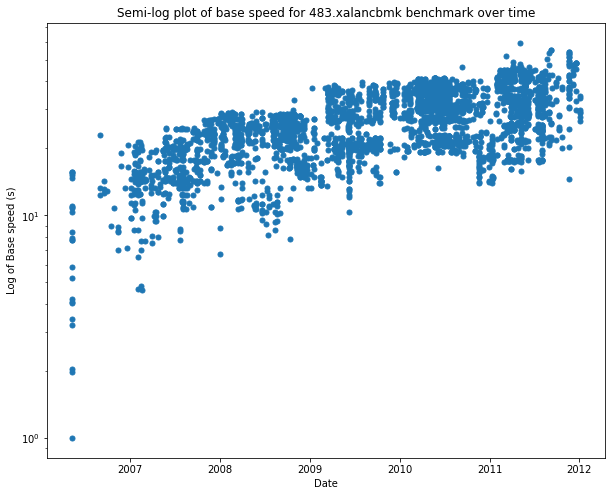

In [24]:
plt.figure(figsize=(10, 8))
plt.title("Semi-log plot of base speed for 483.xalancbmk benchmark over time")
plt.xlabel("Date")
plt.ylabel("Log of Base speed (s)")
plt.semilogy(x, y, linestyle="",marker="o", ms=5)

## Fitting a linear model to the plot

In [25]:
from sklearn.linear_model import LinearRegression
import numpy as np
import datetime as dt

In [26]:
#Convert datetime to a numerical format for regression
x_numeric = x.map(dt.datetime.toordinal)

#Reshape x as it has only 1 feature
x_numeric = np.array(x_numeric).reshape(-1, 1)

In [27]:
model = LinearRegression()
model.fit(x_numeric, y)

#Resulting regression equation
print("y =", model.intercept_,"+", model.coef_, "x")

y = -8039.740494043073 + [0.01099403] x


# Re-plotting data with regression line

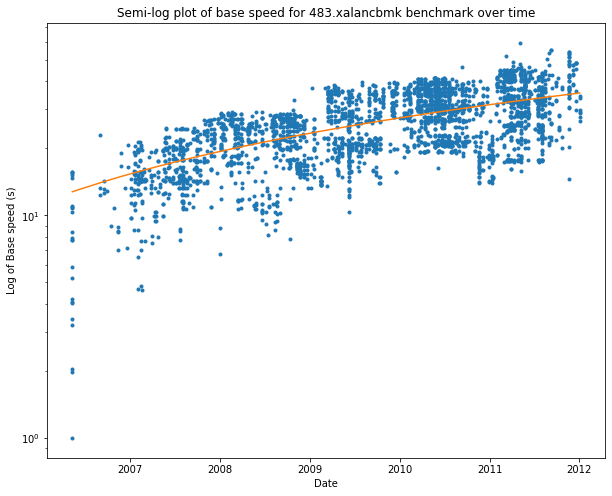

In [28]:
plt.figure(figsize=(10, 8))
plt.title("Semi-log plot of base speed for 483.xalancbmk benchmark over time")
plt.xlabel("Date")
plt.ylabel("Log of Base speed (s)")
plt.semilogy(x, y, linestyle="",marker="o", ms=3)
#Adding regression line: x values and predicted y values
plt.semilogy(x_numeric, model.predict(x_numeric))
plt.show()

## Moore's law – does it hold?

"[Moore's] law states that processor speeds, or overall processing power for computers will double every two years." (mooreslaw.org, 2019). This motivates the question, is the historical data from this specific benchmark consisent with the claim of Moore's law?

Now that we have gone through the processes of fitting a linear regression to this benchmark data, it seems a reasonalbe place to start. We have that y = -8039.740494043073 + [0.01099403]x, where y is the Base speed of the benchmark–a proxy for computing power–and x is the date in ordinal format.

In [29]:
x.max() - x.min()

Timedelta('2060 days 00:00:00')

There were 5.64 years (2060 days) between the first and the last run of the benchmark. Moore's law predicts a seven-fold improvement during that time period, 2^(5.64/2)=7.06. Expressed equivalently, the performance should have had time to double 5.64/2=2.82 times.

In [30]:
#Re-shape for regression compatibility
first_date = np.array(x_numeric.min()).reshape(-1, 1)
last_date  = np.array(x_numeric.max()).reshape(-1, 1)

#Plug date into regression to get estimates
first_performance = model.predict(first_date)
last_performance = model.predict(last_date)
print("performance in 2006:", first_performance,
     "\n performance in 2012:", last_performance)

performance in 2006: [12.76854913] 
 performance in 2012: [35.41624456]


The regression model predict it took 12.77s, to run the benchmark in 2006 and 35.42 in 2012. This is equivalent to a 2.78 times improvement. This is not even half of the performance improvement predicted by Moore's law. It would thus seem that Moore's law did not hold for this benchmark in this timeperiod. 

However, we could get more granular, and consider a whether it held for some period of time following 2006. We can convert Moore's law into a daily performance improvement by asking the question: If you want a doubling every two years, how much do you have to improve every day?
Answering this mathematically by solving for x: k*x^730 = 2k, we have x = 2^(1/730).

We can now plot this alongside our regression line to visually compare them. We assume the the base speed at the first time period in the data set is the starting point for the Moore's improvement.

In [31]:
#Calculating improvement predicted by Moore's
moore = []
for time in x_numeric:
    days_elapsed = time - x_numeric.min()
    moore.append(first_performance*2**(days_elapsed/730))

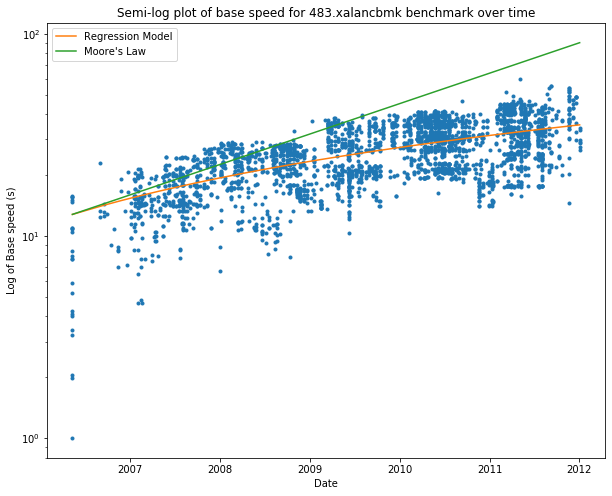

In [32]:
plt.figure(figsize=(10, 8))
plt.title("Semi-log plot of base speed for 483.xalancbmk benchmark over time")
plt.xlabel("Date")
plt.ylabel("Log of Base speed (s)")
plt.semilogy(x, y, linestyle="",marker="o", ms=3)
#Adding regression line: x values and predicted y values
plt.semilogy(x_numeric, model.predict(x_numeric), label="Regression Model")
plt.semilogy(x_numeric, moore, label="Moore's Law")
plt.legend(loc='upper left')
plt.show()

This graph paints a more nuanced picture. We can clearly see the divergence from of the regression estimates from the Moore's Law predictions. Moreover, looking at the slopes of the lines yields more insight still: the Moore's law prediction, which is exponential, is completely linear as the y-axis is logged; the slope of the regression model, as percieved on the logged axis, gradually flattens over time. From this we can infer that the pace of improvement has been decreasing. Moore's law was almost true in the beginning of the benchmark, and became less so over time.

We can even examine the how the change in the rate of divergence between Moore's law and the benchmark over time. 

In [46]:
divergence_rate = []
for i in range(len(1, moore)):
    last_difference = 

SyntaxError: unexpected EOF while parsing (<ipython-input-46-87b6a07b2cdc>, line 3)

# Mnist Digits
No machine learning course would be complete without using the MNIST dataset. This dataset was a hugely influential dataset of handwritten digits (0-9).

In [34]:
from sklearn.datasets import load_digits

# Exploring the dataset; plotting some numbers

<Figure size 432x288 with 0 Axes>

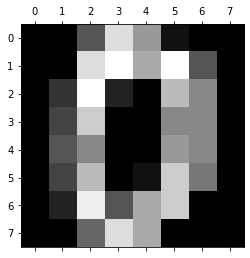

<Figure size 432x288 with 0 Axes>

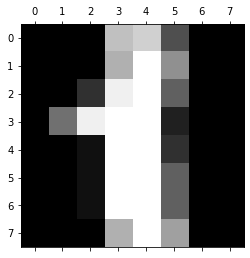

<Figure size 432x288 with 0 Axes>

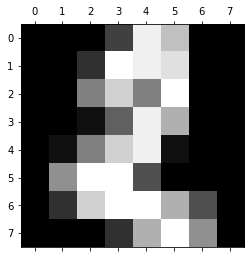

<Figure size 432x288 with 0 Axes>

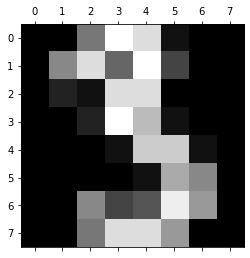

<Figure size 432x288 with 0 Axes>

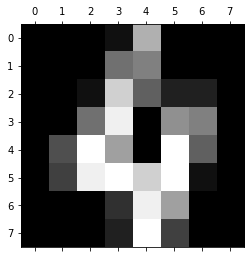

<Figure size 432x288 with 0 Axes>

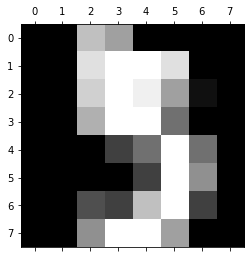

<Figure size 432x288 with 0 Axes>

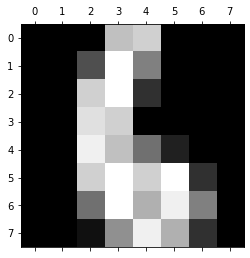

<Figure size 432x288 with 0 Axes>

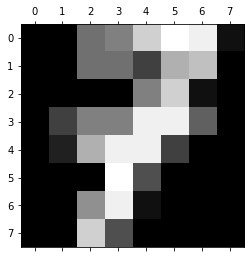

<Figure size 432x288 with 0 Axes>

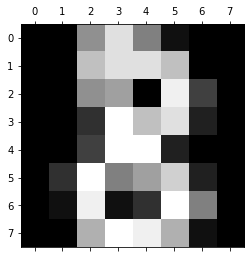

<Figure size 432x288 with 0 Axes>

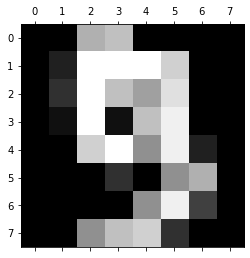

In [35]:
#Load two classes of digits
digits = load_digits()

#Plot examples of digits 0-9 to get a feeling for the dataset
for i in range(10):
    plt.gray()
    plt.matshow(digits.images[i])
    plt.show() 

# Classifying with 5's vs 6's
## Pre-processing

In [36]:
'''As I was experimenting with different number pairs,
I figured making a function of it was best 
(many number pairs gave perfect classifications for every K I tested).
'''

def load_2digits(a, b):
    '''
    Returns array X with data and
    array y with targets 
    for two digits a, b in MNIST
    '''
    #Load entire data set
    digits = load_digits()
    y = digits.target
    
    #Extract desired subset
    indices = np.where((y == a) | (y == b))[0]
    X = digits.data[indices]
    y = digits.target[indices]
    
    return X, y

Choosing 5's and 6's because they get imperfect scores

In [37]:
X, y = load_2digits(5,6)

Setting aside 20% (73 obs) for testing, remaining 290 obs for training. 
Enough to get good performance, although this seems to work for almost 
any split as the classification problem is on the easy side

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=25)

In [39]:
#shape of train and test objects
print(X_train.shape)
print(X_test.shape)

(290, 64)
(73, 64)


In [40]:
# shape of new y objects
print(y_train.shape)
print(y_test.shape)

(290,)
(73,)


# Model selection

Our aim is to accurately clasify whether a digit image is of a 5 or a 6, given an array representing the image of the digit. We have no preferences as to which types of error are more or less desirable, we simply want to be right as often as possible. Consequently, I have decided progress towards this objective is best captured by classification accuracy.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

In [42]:
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1,26)
scores = {}
scores_list = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(model, X_train, y_train,
                            scoring=['accuracy'], cv=5)
    
    #Store average accuracy accross the five splits
    scores_list.append(np.mean(cv_results['test_accuracy']))

## Plotting test accuracy for each K

Text(0, 0.5, 'Testing Accuracy')

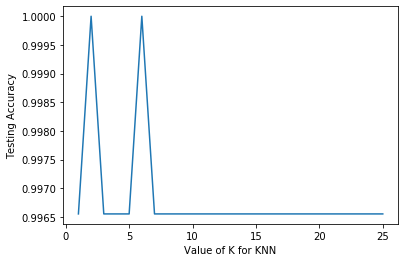

In [43]:
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

K=2 and K=6 both have perfect classification accuracy. Both values of K are relatively small; I choose k=6 for my model as I feel like k=2 might lead to a more unstable decision boundary – I admit this is a rather arbitrary choice.

# Evaluating performance on the test set

In [45]:
#Selecting k=6 and training on the entire training set
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train,y_train)

#Making prediction on the unseen test data
y_pred=model.predict(X_test)
print(accuracy_score(y_test,y_pred))

1.0


Our model correctly classified all 73 digits in the test set.